In [1]:
import os
from classes.VAE import VAEGAN

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchsummary import summary

from torch import distributions as D
import wandb

from imutils import paths
import matplotlib.pyplot as plt
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

In [2]:
encoder_architecture=[[0,64],[0,128],[0,128]]
decoder_architecture=[[0,64],[0,128]]

discriminator_architecture=[[0,64],[0,128],[0,128]]

latent_dim=100
input_dim=(1,28,28)


config={"dataset":"MNIST", "type":"VAEGAN","encoder_architecture":encoder_architecture,"decoder_architecture":decoder_architecture,"discriminator_architecture":discriminator_architecture}
config["latent_dim"]=latent_dim
config["input_dim"]=input_dim

model=VAEGAN(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture,discriminator_architecture=discriminator_architecture,discriminator_dense=100)

#model=VAE(input_dim,latent_dim)

C:\Users\matte\anaconda3\envs\ai_pytorch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [3]:
images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
#images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

#other important definitions

EPOCHS=10
BS=512
INIT_LR=1e-4

config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


In [4]:
summary(model.vae.encoder,(1,28,28),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
      ConvResBlock-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
      ConvResBlock-4            [-1, 128, 7, 7]               0
            Conv2d-5            [-1, 128, 3, 3]         262,272
      ConvResBlock-6            [-1, 128, 3, 3]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                  [-1, 100]         115,300
            Linear-9                  [-1, 100]         115,300
Total params: 625,160
Trainable params: 625,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 2.38
Estimated Total Size (MB): 2.70
-------------------------------------------

In [5]:
summary(model.vae.decoder,(latent_dim,),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         316,736
         Unflatten-2             [-1, 64, 7, 7]               0
   ConvTranspose2d-3           [-1, 64, 14, 14]          65,600
             PReLU-4           [-1, 64, 14, 14]               1
ConvTransposeResBlock-5           [-1, 64, 14, 14]               0
   ConvTranspose2d-6          [-1, 128, 28, 28]         131,200
             PReLU-7          [-1, 128, 28, 28]               1
ConvTransposeResBlock-8          [-1, 128, 28, 28]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]           1,153
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 514,691
Trainable params: 514,691
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.64
Params size (MB): 1.96
Estim

In [6]:
summary(model.discriminator,(1,28,28),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
      ConvResBlock-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
      ConvResBlock-4            [-1, 128, 7, 7]               0
            Conv2d-5            [-1, 128, 3, 3]         262,272
      ConvResBlock-6            [-1, 128, 3, 3]               0
           Flatten-7                 [-1, 1152]               0
           Flatten-8                 [-1, 1152]               0
            Linear-9                  [-1, 100]         115,300
           Linear-10                  [-1, 100]         115,300
          Dropout-11                  [-1, 100]               0
          Dropout-12                  [-1, 100]               0
        LeakyReLU-13                  [-1, 100]               0
        LeakyReLU-14                  [

## Dataloaders

In [7]:
transform=Compose([ToTensor()])

train_dataset=MNIST('mnist_train', train=True, download=True,
                             transform=transform)
test_dataset=MNIST('mnist_test', train=False, download=True,
                             transform=transform)


C:\Users\matte\anaconda3\envs\ai_pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BS,shuffle=True)


## Train Loop

In [9]:
base_path="models/vae_mnist"
os.makedirs(base_path,exist_ok=True)

In [10]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [11]:
wandb.init(project="NeuroGEN_Pytorch",config=config)

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Val 0: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.47batch/s, d_accuracy=0, d_loss=0.436, loss=0.0632]


(272, 28, 28, 1) (100, 28, 28, 3)


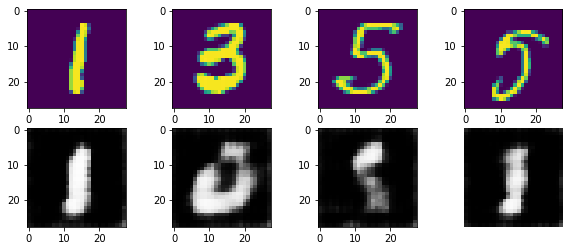

Val 1: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.02batch/s, d_accuracy=0, d_loss=0.628, loss=0.0487]


(272, 28, 28, 1) (100, 28, 28, 3)


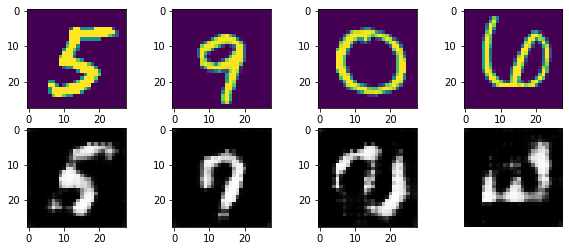

Val 2: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.78batch/s, d_accuracy=0, d_loss=0.687, loss=0.0426]


(272, 28, 28, 1) (100, 28, 28, 3)


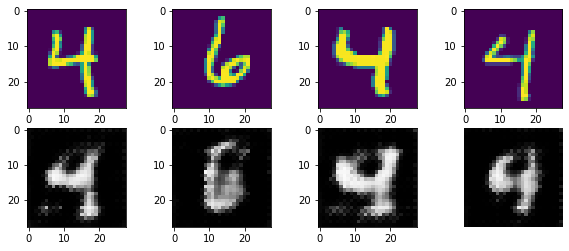

Val 3: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.84batch/s, d_accuracy=0, d_loss=0.706, loss=0.0376]


(272, 28, 28, 1) (100, 28, 28, 3)


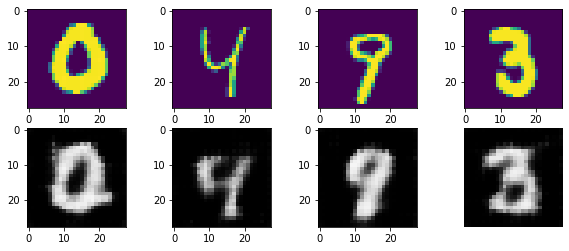

Val 4: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.91batch/s, d_accuracy=0, d_loss=0.708, loss=0.0361]


(272, 28, 28, 1) (100, 28, 28, 3)


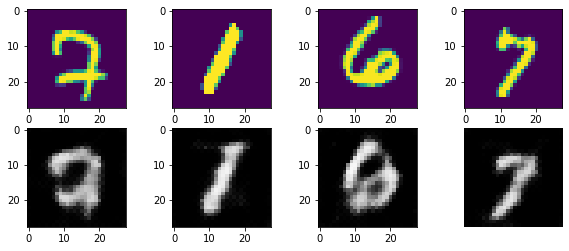

Val 5: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.89batch/s, d_accuracy=0, d_loss=0.699, loss=0.0344]


(272, 28, 28, 1) (100, 28, 28, 3)


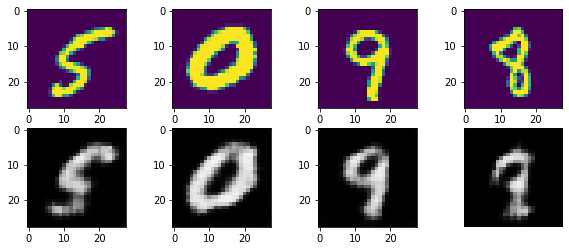

Val 6: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.63batch/s, d_accuracy=0, d_loss=0.672, loss=0.0323]


(272, 28, 28, 1) (100, 28, 28, 3)


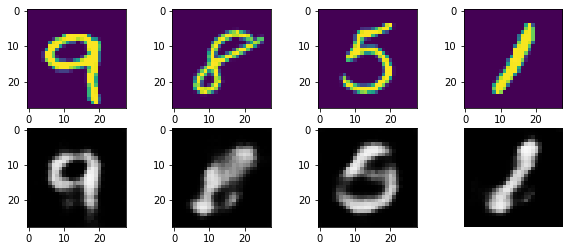

Val 7: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.85batch/s, d_accuracy=0, d_loss=0.676, loss=0.0318]


(272, 28, 28, 1) (100, 28, 28, 3)


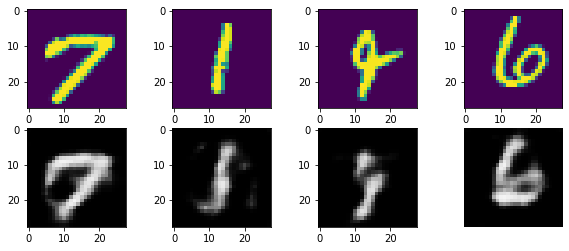

Val 8: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.96batch/s, d_accuracy=0, d_loss=0.671, loss=0.0312]


(272, 28, 28, 1) (100, 28, 28, 3)


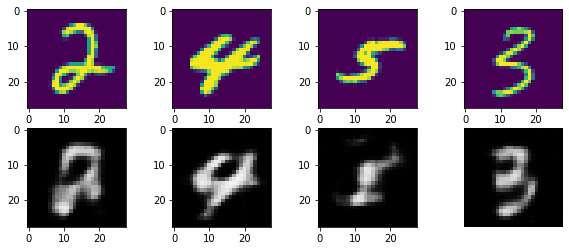

Val 9: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.97batch/s, d_accuracy=0, d_loss=0.657, loss=0.0296]


(272, 28, 28, 1) (100, 28, 28, 3)


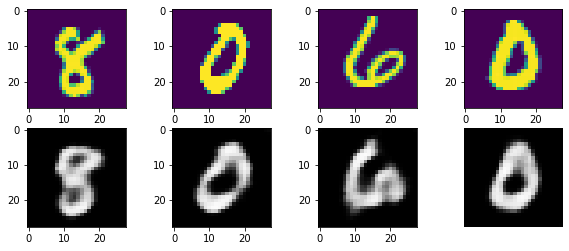

In [12]:

#model.load_state_dict(torch.load(r"models/vae/model.ckp"))

d_optimizer=torch.optim.Adam(model.discriminator.parameters(),lr=INIT_LR)
v_optimizer=torch.optim.Adam(model.vae.parameters(),lr=INIT_LR)
g_optimizer=torch.optim.Adam(model.vae.decoder.parameters(),lr=INIT_LR)

model.to(device)

model.fit(train_dataloader=train_dataloader,val_dataloader=test_dataloader,epochs=EPOCHS,d_optimizer=d_optimizer,v_optimizer=v_optimizer,g_optimizer=g_optimizer,device=device,wandb_log=True,save_model=base_path,early_stop=3)

In [13]:
x,y=next(iter(test_dataloader))

In [14]:
x2=model(x.to(device))

In [15]:
x2.shape

torch.Size([512, 1, 28, 28])

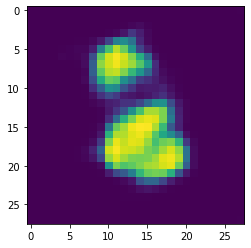

In [16]:
plt.imshow(x2[0].cpu().detach().permute(1,2,0).numpy())

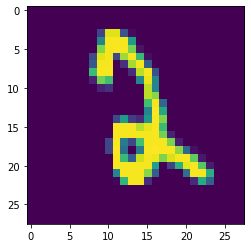

In [17]:
plt.imshow(x[0].cpu().permute(1,2,0).numpy()*255)